# TCAD Parcel Downloader

This notebook downloads the polygons bounding the land associated with each property.

You can open this dataset in an interactive map found here:
http://www.arcgis.com/apps/mapviewer/index.html?url=https://services.arcgis.com/0L95CJ0VTaxqcmED/ArcGIS/rest/services/EXTERNAL_tcad_parcel/FeatureServer&source=sd


Documentation found in the query method of ARCGIS Rest API. 

In [9]:
import pandas as pd
import geopandas as gpd

import osmnx as ox 

# Input files
ZIP_POLYGONS_ATX = "data/processed/tl_2023_us_zcta520_travis.parquet"

# Output files
TCAD_PARCELS_78733 = "data/processed/tcad_gis_parcels_78733.parquet"
TCAD_PARCELS_78741 = "data/processed/tcad_gis_parcels_78741.parquet"

In [2]:
atx_polygons = gpd.read_parquet(ZIP_POLYGONS_ATX)
polygon_78741 = atx_polygons.loc[['78741']]
polygon_78733 = atx_polygons.loc[['78733']]

## Functions

The way this works is that the notebook will first download all the parcels in a rectangular area that includes the zip code.
Then, the zip code shape is used to further remove parcels that are outside the zip code, which is why there are two images for each zip code below.

In [3]:
from urllib.parse import urlencode

def create_query_url(*,xmin,ymin,xmax,ymax,bbox_crs=4326,output_crs=4326):
    base_url = 'https://gis.traviscountytx.gov/server1/rest/services/Boundaries_and_Jurisdictions/TCAD_public/MapServer/0/query?'
    
    params = {
        'f':'geojson',
        'returnGeometry':True,
        'spatialRel':'esriSpatialRelIntersects',
        'geometry':f'{{xmin:{xmin},ymin:{ymin},xmax:{xmax},ymax:{ymax},spatialReference:{{wkid:{bbox_crs}}}}}',
        'geometryType':'esriGeometryEnvelope',
        'inSr':bbox_crs,
        'outFields':'OBJECTID,PROP_ID,geo_id,situs_num,situs_street,situs_zip,situs_address,sub_dec,entities,tcad_acres,legal_desc,hyperlink,SHAPE.STArea(),SHAPE.STLength(),situs_street_prefx,situs_street_suffix,situs_city',
        'outSR':output_crs
    }
    url = base_url+urlencode(params,quote_via=(lambda s,*args,**kwargs:s))
    return url

def download(url):
    results = []
    result_offset = 0

    # Depaginator
    while True:
        gdf = gpd.read_file(f'{url}&resultOffset={result_offset}')
        if len(gdf)<=0:
            break
        results.append(gdf)
        result_offset += 1000
    return pd.concat(results)

# Gets the rectangle bounding each shape.
def get_bounds(polygon_row):
    if not (isinstance(polygon_row,gpd.GeoDataFrame) and len(polygon_row)==1):
        raise ValueError("Please provide polygon_row in the form of a GeoDataFrame with one row")
    bbox = polygon_row.exterior.bounds.iloc[0]
    return {'xmin':bbox.minx,'ymin':bbox.miny,'xmax':bbox.maxx,'ymax':bbox.maxy}



## Getting the Land Parcels for 78733

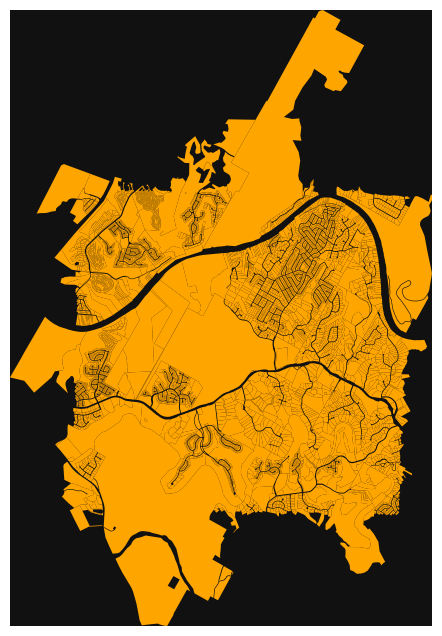

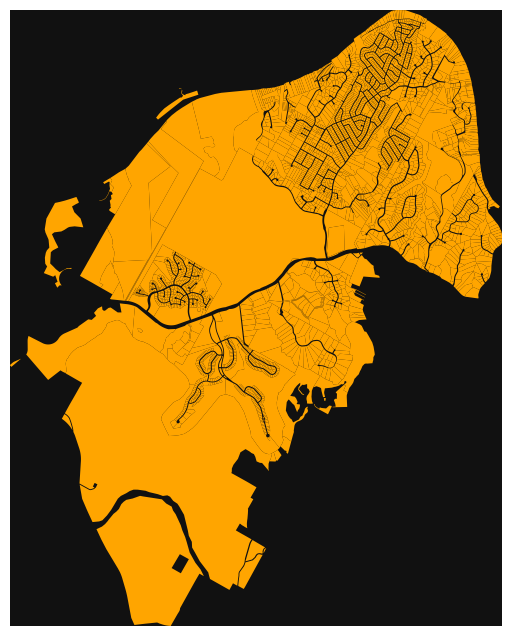

In [4]:
url = create_query_url(**get_bounds(polygon_78733))

output = download(url)

ox.plot_footprints(output)
tcad_parcels_78733 = output.sjoin(polygon_78733)
ox.plot_footprints(tcad_parcels_78733)
tcad_parcels_78733.to_parquet(TCAD_PARCELS_78733)

## Getting the Land Parcels for 78741

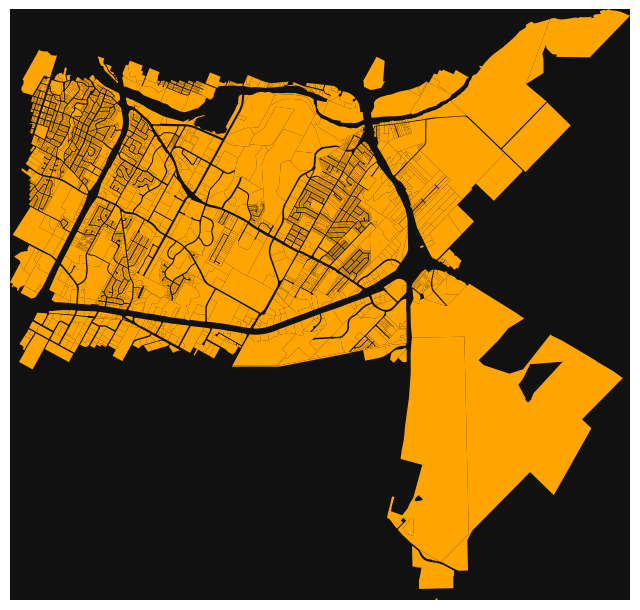

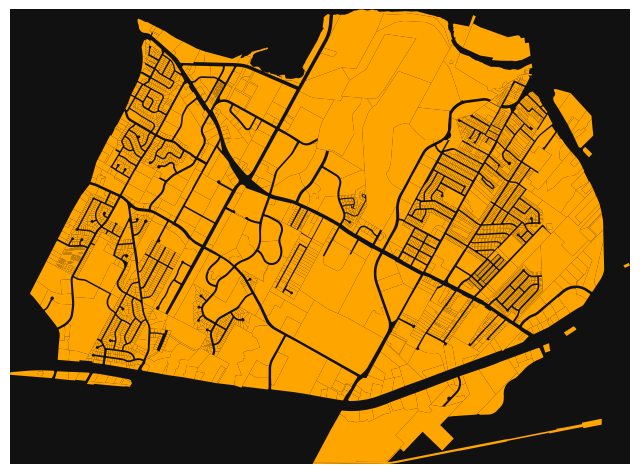

In [5]:
url = create_query_url(**get_bounds(polygon_78741))

output = download(url)

ox.plot_footprints(output)
tcad_parcels_78741 = output.sjoin(polygon_78741)
ox.plot_footprints(tcad_parcels_78741)

tcad_parcels_78741.to_parquet(TCAD_PARCELS_78741)

In [21]:
#polygon_78733.sindex.valid_query_predicates

In [11]:
# output.sindex.query(polygon_78733['geometry'])